##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

This colab demonstrates how to:
1. Load BiT models in PyTorch
2. Make predictions using BiT pre-trained on ImageNet
3. Fine-tune BiT on 5-shot CIFAR10 and get amazing results!

It is good to get an understanding or quickly try things. However, to run longer training runs, we recommend using the commandline scripts at http://github.com/google-research/big_transfer

In [ ]:
from functools import partial
from collections import OrderedDict

In [ ]:
%config InlineBackend.figure_format = 'retina'

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision as tv

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from __future__ import print_function, division

import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy

plt.ion()   # interactive mode

# Reading weight data from the Cloud bucket

In [ ]:
import requests
import io

In [ ]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [ ]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

# Defining the architecture and loading weights

In [ ]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [ ]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [ ]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [ ]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [ ]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

# Boilerplate

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

# Fine-Tune Bit-M on CoronaHack Dataset

## download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

# Before you do the following, make sure to first upload a Kaggle token json 
# file to /content/gdrive/MyDrive/Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
# /content/gdrive/MyDrive/Kaggle is the path where kaggle.json is present in the Google Drive
!mkdir /content/gdrive/MyDrive/Kaggle/CoronaHack
%cd /content/gdrive/MyDrive/Kaggle/CoronaHack

# Download dataset from Kaggle
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

## label dataset

In [ ]:
metadata_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Chest_xray_Corona_Metadata.csv"
metadata = pd.read_csv(metadata_path, index_col=0)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
normal_meta = metadata[metadata["Label"] == "Normal"]
virus_meta = metadata[metadata["Label_1_Virus_category"] == "Virus"]
# covid_meta = metadata[metadata["Label_2_Virus_category"] == "COVID-19"]
# other_meta = metadata[(metadata["Label"] == "Pnemonia") & (metadata["Label_2_Virus_category"] != "COVID-19")]
print(normal_meta.shape[0], virus_meta.shape[0])

1576 1555


In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
!mkdir $data_dir
normal_dir = f"{data_dir}/normal"
virus_dir = f"{data_dir}/virus"
# covid_dir = f"{data_dir}/covid19"
# other_dir = f"{data_dir}/other"
dir_dict = {
    normal_dir: normal_meta, 
    virus_dir: virus_meta,
    # covid_dir: covid_meta,
    # other_dir: other_meta,
}
for dir in dir_dict.keys():
  if not os.path.exists(dir):
    os.mkdir(dir)
old_data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

for dir, meta in dir_dict.items():
  for im in meta["X_ray_image_name"]:
    if os.path.exists(f"{old_data_dir}/train/{im}"):
      os.rename(f"{old_data_dir}/train/{im}", f"{dir}/{im}")
    elif os.path.exists(f"{old_data_dir}/test/{im}"):
      os.rename(f"{old_data_dir}/test/{im}", f"{dir}/{im}")

## load dataset

In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
data_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        # tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

image_datasets = datasets.ImageFolder(data_dir, data_transforms)

In [ ]:
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes, class_names)

3131 ['normal', 'virus']


In [ ]:
val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
print(len(train_dataset), len(val_dataset), len(test_dataset))

2193 469 469


In [ ]:
dataloaders = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders))

# # Make a grid from batch
# out = tv.utils.make_grid(inputs)

# imshow(out)

## fine-tuning

In [ ]:
def eval_corona(model, dataset, bs=100):
  loader_test = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False)

  model.eval()

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.to(device)
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / len(dataset)

In [ ]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=2, zero_head=True)
model.load_from(weights)
model.to(device)

ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, af

In [ ]:
# crit = nn.CrossEntropyLoss()
lr=0.1
save_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/bitm_20.pth"
crit = nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters(), lr=lr)
model.train();

In [ ]:
iters = 20

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in dataloaders:
    x, t = x.to(device), t.to(device)
    logits = model(x)
    loss = crit(logits, t)
    loss.backward()
    opti.step()
    opti.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / len(train_dataset)
  accus_train.append([])

  accus_val.append(eval_corona(model, val_dataset, bs=64))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        f'(lr={lr:g})'
        # , end=''
        , flush=True)
  
  lr = lr * 0.9
  for param_group in opti.param_groups:
    param_group['lr'] = lr
  torch.save(model, save_path)
  # break

[Step 1] loss=1.78e+03 train accu=51.48% validation accu=52.88% (lr=0.1)
[Step 2] loss=3.48e+02 train accu=50.98% validation accu=47.12% (lr=0.09)
[Step 3] loss=8.77e+01 train accu=61.88% validation accu=81.02% (lr=0.081)
[Step 4] loss=3.52e+01 train accu=74.65% validation accu=84.65% (lr=0.0729)
[Step 5] loss=1.97e+01 train accu=80.44% validation accu=82.09% (lr=0.06561)
[Step 6] loss=1.94e+01 train accu=79.66% validation accu=53.52% (lr=0.059049)
[Step 7] loss=2.01e+01 train accu=81.35% validation accu=86.14% (lr=0.0531441)
[Step 8] loss=1.45e+01 train accu=83.04% validation accu=87.42% (lr=0.0478297)
[Step 9] loss=1.15e+01 train accu=86.46% validation accu=85.07% (lr=0.0430467)
[Step 10] loss=1.22e+01 train accu=86.09% validation accu=81.24% (lr=0.038742)
[Step 11] loss=1.37e+01 train accu=83.90% validation accu=80.60% (lr=0.0348678)
[Step 12] loss=1.31e+01 train accu=84.72% validation accu=87.21% (lr=0.0313811)
[Step 13] loss=1.10e+01 train accu=87.28% validation accu=86.78% (lr=0.

In [ ]:
accus_test = eval_corona(model, test_dataset, bs=64)
print(accus_test)

tensor(0.8678, device='cuda:0')


Text(0.5, 1.0, 'training & validation accuracy')

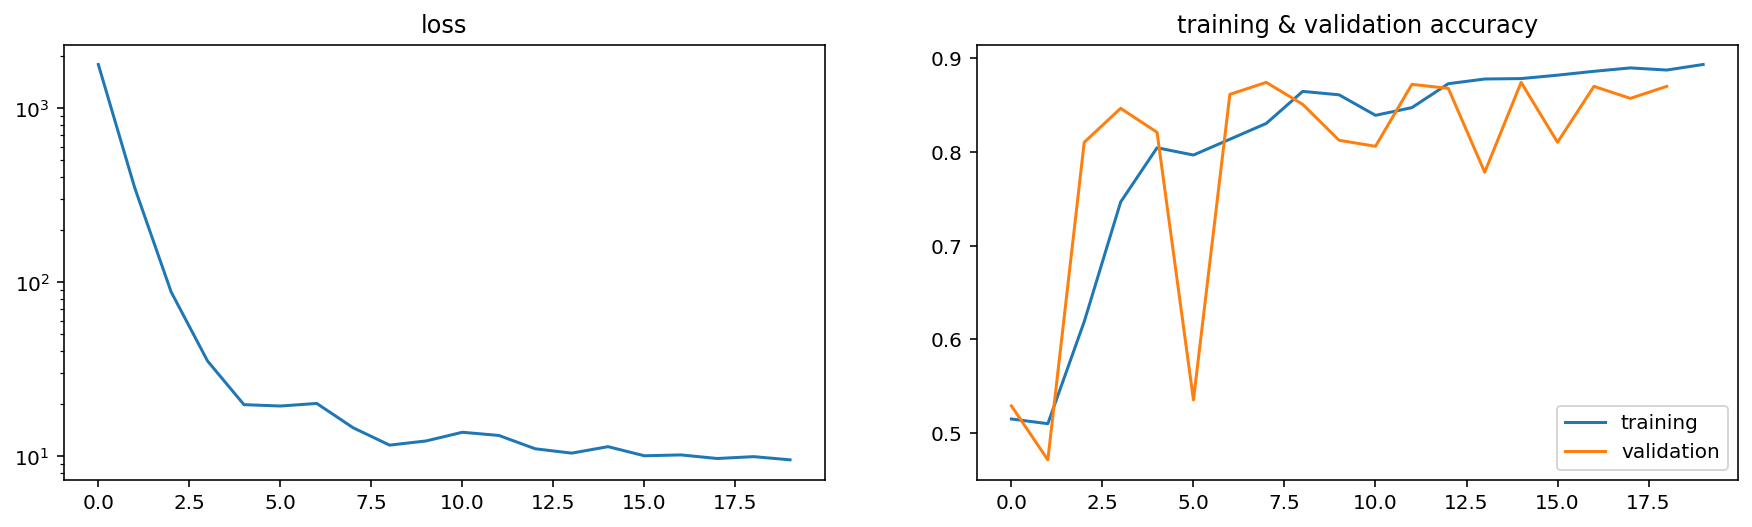

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1], label="training")
ax2.plot(accus_val[:-1], label="validation")
ax2.legend()
ax2.set_title('training & validation accuracy')
# ax2.set_title('validation accuracy');

In [ ]:
save_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/bitm_20.pth"
model = torch.load(save_path)
model.eval()
print(type(model))

In [ ]:
print(losses)
print(accus_train)
print(accus_val)

[1780.4120065569878, 347.9025648236275, 87.72060561180115, 35.17120870947838, 19.735332548618317, 19.38101516664028, 20.054011151194572, 14.529527321457863, 11.549643784761429, 12.205151811242104, 13.693955928087234, 13.130672007799149, 11.004657328128815, 10.388259649276733, 11.317742869257927, 10.030152335762978, 10.14883916825056, 9.675971522927284, 9.917867943644524, 9.507550969719887, []]
[tensor(0.5148, device='cuda:0'), tensor(0.5098, device='cuda:0'), tensor(0.6188, device='cuda:0'), tensor(0.7465, device='cuda:0'), tensor(0.8044, device='cuda:0'), tensor(0.7966, device='cuda:0'), tensor(0.8135, device='cuda:0'), tensor(0.8304, device='cuda:0'), tensor(0.8646, device='cuda:0'), tensor(0.8609, device='cuda:0'), tensor(0.8390, device='cuda:0'), tensor(0.8472, device='cuda:0'), tensor(0.8728, device='cuda:0'), tensor(0.8778, device='cuda:0'), tensor(0.8782, device='cuda:0'), tensor(0.8819, device='cuda:0'), tensor(0.8860, device='cuda:0'), tensor(0.8896, device='cuda:0'), tensor(0

## activation max

In [ ]:
!pip install flashtorch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from flashtorch.activmax import GradientAscent

In [ ]:
g_ascent = GradientAscent(model)
g_ascent.use_gpu = True
heatmap_layer = model.head.conv

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


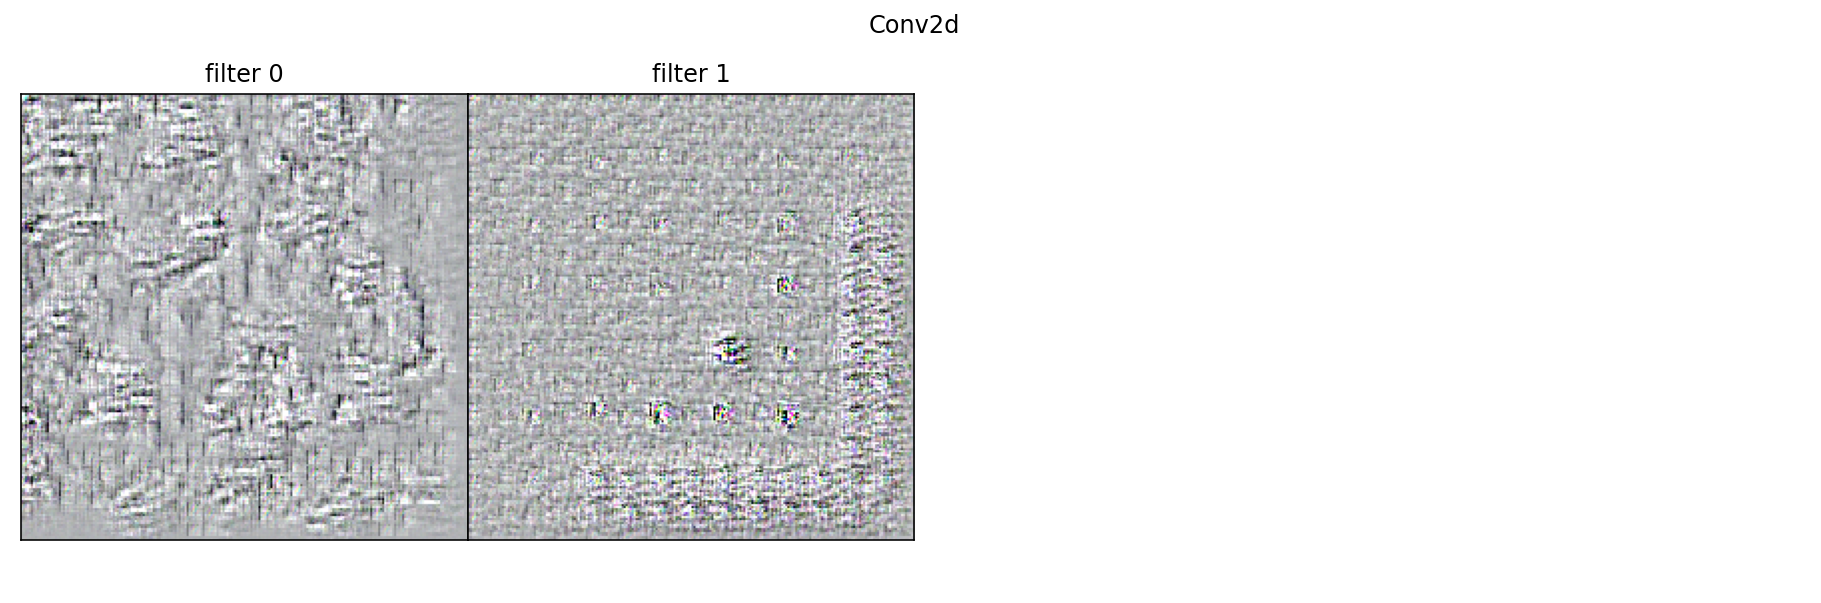

In [ ]:
g_ascent.visualize(heatmap_layer, [0, 1])

In [ ]:
vit_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/vit_10.pth"
vit = torch.load(save_path)
vit.eval()
vit_ascent = GradientAscent(vit)
vit_ascent.use_gpu = True
vit_heatmap_layer = vit.head.conv
# vit_heatmap_layer = vit.body.block4.unit03.conv3

In [ ]:
for i in vit.named_children():
  print(i)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


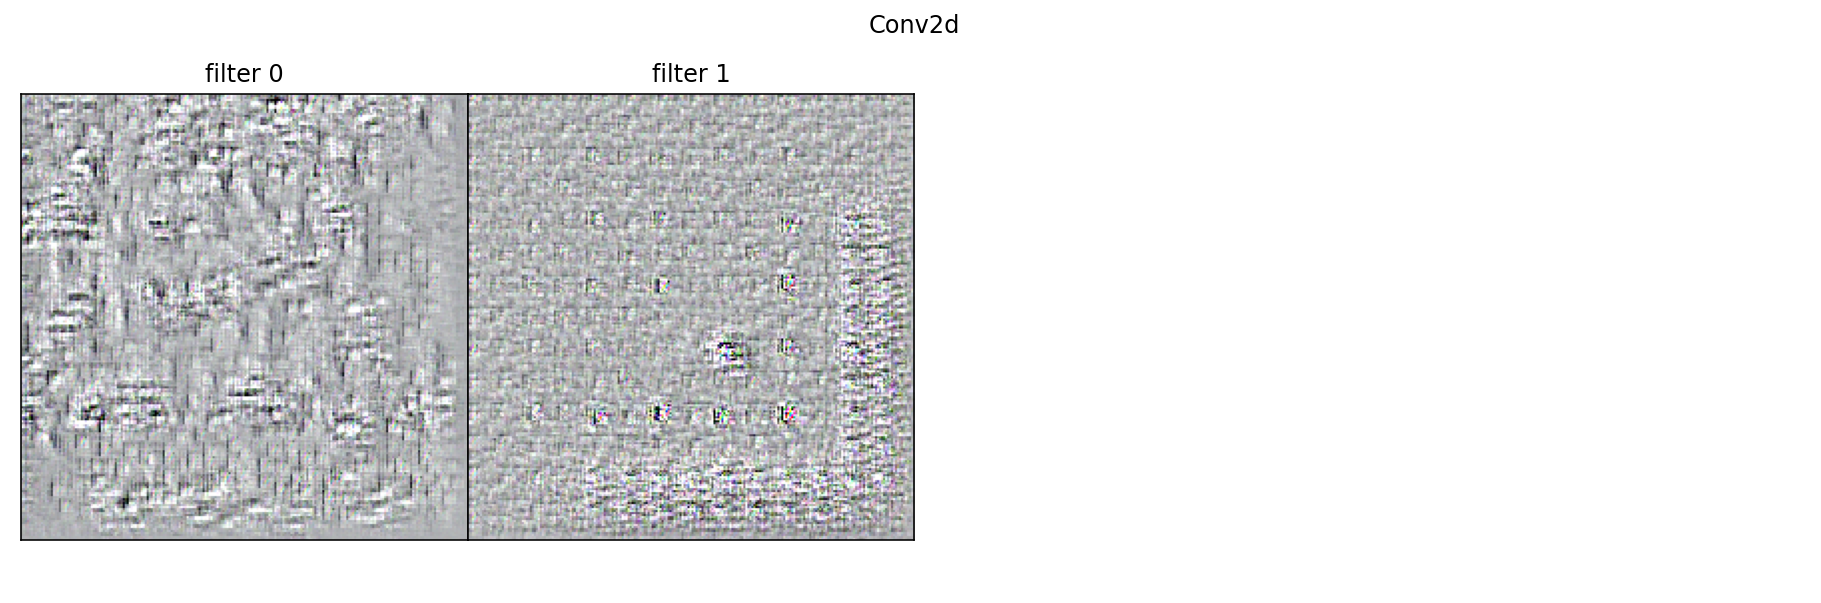

In [ ]:
#  print(vit_heatmap_layer)
vit_ascent.visualize(vit_heatmap_layer, [0, 1])

# Citation

Kolesnikov, A., Beyer, L., Zhai, X., Puigcerver, J., Yung, J., Gelly, S., and Houlsby, N. (2020). Big transfer (bit): General visual representation learning.

Ogura, M. and Jain, R. (2020). Misaogura/flashtorch: 0.1.2.
